In [1]:
%pylab inline
%load_ext autoreload

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import json
from collections import defaultdict
from functools import reduce
import copy
import numpy as np


import datetime as dt
pd.set_option('display.max_columns', 500)

import time
%load_ext autoreload

from collections import defaultdict
from collections import Counter

from functools import lru_cache
import seaborn as sns

from scipy.special import expit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Complexity 72h code

# PACKAGES
import numpy as np
import random

# CLASSES

# Individual
class agent():
    def __init__(self, number, coop, payoff=0):
        self.number = number
        self.coop = coop
        self.payoff = payoff
        
        self.backup = list()

    #change the coop variable
    def set_coop(self, coop):
        self.coop = coop

    def __repr__(self):
        return(f"Hi I'm agent {self.number}, I'm {self.coop}")
    
    def save_stuff(self):
        self.backup.append((self.coop,self.payoff))
        



# Network
class circle():
    def __init__(self, n, p, w, b, c=1, all_coop = True):
        self.b = b
        self.c = c

        self.p = p
        self.n = n
        self.w = w
        self.arr = [agent(i, all_coop) for i in range(n)]
        
        self.global_coop = n if all_coop else 0



        
    def access(self, index): # for accessing
        return self.arr[index%self.n]
    
    def accessIndex(self, index):
        return index%self.n

    def choose_one_rand(self): #pick one node at random
        index = np.random.choice(self.n, 1)[0]
        return self.access(index)
    
    def choose_index_rand(self): #pick one node at random
        return random.randrange(0, self.n)
    
    
    
    

    def flip_agent(self, index_flipped): #initialize the ring with 1 cooperator
        current = self.access(index_flipped)
        current.coop = not current.coop
        
        if current.coop: self.global_coop += 1
        else: self.global_coop -= 1
        

    def count_coop(self):
        return sum([i.coop for i in self.arr])


    def make_action(self): #iterazione
        
        self.update_all_payoff()
        
        index = self.choose_index_rand()
        if random.random() > self.p:
            self.action_local_on(index)
        else:
            self.action_global_on(index)
        
        #[i.save_stuff() for i in self.arr]
        
        #string = "-"
        #for i in self.arr:
        #    string += "c-" if i.coop else "d-"
        #print(string)
        
        
        

    # take a local action
    def action_local_on(self, index):
        # select left or rigth
        #if random.random() > 0.5:
        #    choosen = self.accessIndex(index+1)  
        #else:
        #    choosen = self.accessIndex(index-1)
        
        ###################
        
        random_tmp = random.random()
        
        A = self.w * self.access(index).payoff
        B = self.w * self.access(index+1).payoff
        C = self.w * self.access(index-1).payoff
        
        logitA = expit( A ) / ( expit( C ) + expit( B ) + expit( A ) )
        logitB = expit( B ) / ( expit( C ) + expit( B ) + expit( A ) )
        logitC = expit( C ) / ( expit( C ) + expit( B ) + expit( A ) )
               
        if random_tmp < logitC: 
            choosen = self.accessIndex(index-1)
        elif (random_tmp >= logitC) and (random_tmp <  logitC + logitA): 
            choosen = self.accessIndex(index)
        else:
            choosen = self.accessIndex(index+1)
        
        ###################
        
        
        
        self.copy_strategy(index, choosen)
                

            

    # take a global action
    def action_global_on(self, index):
        choosen_as_rand = self.choose_one_rand().number
        self.copy_strategy(index, choosen_as_rand)


            
    # compute logistic prob
    def copy_strategy(self, index, neighbor_index):
        # return true: if we need to copy the strategy of the other
        # return false: if we need to kepp the strategy
        exponent =  self.w * (self.access(index).payoff - self.access(neighbor_index).payoff)
        copy = random.random() > expit(exponent) 
        
        #if exponent > 1000:
        #    copy = True
        #elif exponent < -1000: 
        #    return
        #else:
        #    copy = random.random() > 1/(1+np.exp(-exponent))
    
        if copy:
            self.access(index).coop = self.access(neighbor_index).coop
            self.global_coop = sum([i.coop for i in self.arr])
            #if self.access(neighbor_index).coop: self.global_coop += 1
            #else: self.global_coop -= 1
        
        

    def update_all_payoff(self):
        for a in self.arr:
            if a.coop:
                #give to other the payoff
                self.access(a.number + 1).payoff += self.b
                self.access(a.number - 1).payoff += self.b
                a.payoff -= 2 * self.c
            else:
                pass

            
            
            

In [119]:
c = circle(10, p=0, w=0.5, b=4, all_coop=False)
c.flip_agent(0)

In [68]:
#%%timeit
#c.make_action()

44.9 µs ± 1.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [137]:
#%%capture
#%timeit


c = circle(500, p=0, w=0.5, b=4.5, all_coop=False)
c.flip_agent(0)

nCoop = list()
itera = 0 
while True:
    itera += 1
    if itera%20 == 0:
        nCoop.append(c.global_coop)
    
    #print(c.global_coop)
    #nCoop.append(c.global_coop)
    if c.global_coop == 0 or c.global_coop == c.n: 
        break
        
    c.make_action()

In [138]:
itera

787

In [139]:
len(nCoop)

39

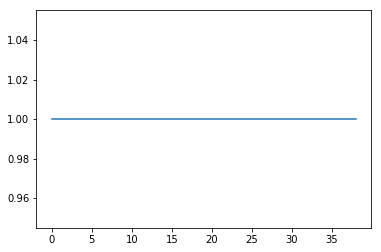

In [140]:
plt.plot(nCoop)

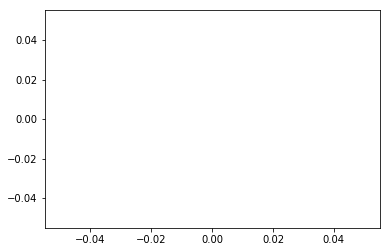

In [10]:
#for ag in c.arr:
#    plt.plot([j for i,j in ag.backup])

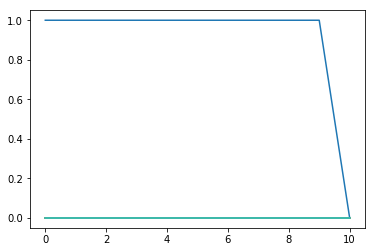

In [77]:
#for ag in c.arr:
#    plt.plot([i for i,j in ag.backup])

# Run Parallel 

In [4]:
from multiprocessing.pool import Pool
from tqdm import tqdm

In [7]:
def runModel(i):
    random.seed(i)
    c = circle(100, p=0, w=0.0001, b=4, all_coop=False)
    c.flip_agent(0)

    nCoop = list()
    itera = 0 
    while True:
        itera += 1
        if itera%20 == 0:
            nCoop.append(c.global_coop)

       
        if c.global_coop == 0 or c.global_coop == c.n: 
            nCoop.append(c.global_coop)
            break

        c.make_action()
    
    return nCoop

In [8]:
nRun = 30
with Pool(4) as p:
      r = list(tqdm(p.imap(runModel, range(nRun)), total=nRun))


100%|██████████| 30/30 [00:29<00:00,  1.01it/s]

In [9]:
tmp = 0
for path in r:
    if path[-1] != 0:
        tmp += 1

print(tmp)
print(tmp/nRun)

5
0.16666666666666666


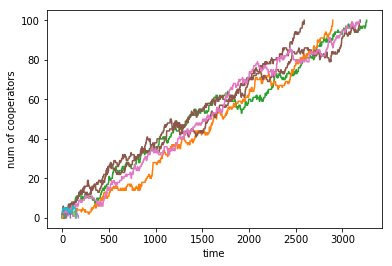

In [10]:
for path in r:
    plt.plot(path)
    plt.xlabel('time')
    plt.ylabel('num of cooperators')
    #plt.title('fuck off we dont know you', fontsize=70)
    plt.savefig('goodone.png')

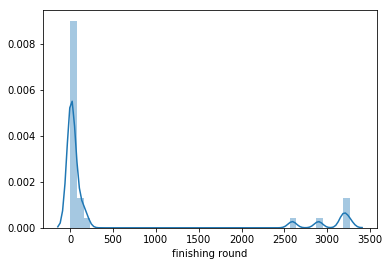

In [11]:
sns.distplot([len(i) for i in r])
plt.xlabel('finishing round')
plt.ylabel('')
plt.savefig('distgoodone.png')

In [8]:
# ratio

In [18]:
final = Counter([i[-1] for i in r])
final

Counter({0: 94, 100: 6})

In [19]:
final[list(final.keys())[0]]/sum(list(final.values()))

0.94

In [20]:
final[list(final.keys())[1]]/sum(list(final.values()))

0.06

# Check exp

In [289]:
exponent = 10
1/(1+np.exp(-exponent))

0.9999546021312976

In [290]:
exponent = -10
1/(1+np.exp(-exponent))

4.5397868702434395e-05

In [325]:
from scipy.special import expit

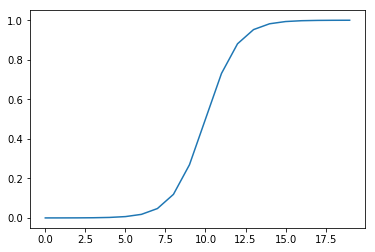

In [326]:
plt.plot([expit(i) for i in range(-10, 10)])